In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from prettytable import PrettyTable
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
holiday = pd.read_csv("holidays_events.csv")
oil = pd.read_csv("oil.csv")
transactions = pd.read_csv("transactions.csv")
store = pd.read_csv("stores.csv")

In [3]:
train['date'] = pd.to_datetime(train['date'])
oil['date'] = pd.to_datetime(oil['date'])

train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year

In [4]:
train.head(10)

,id,date,store_nbr,family,sales,onpromotion,day,month,year
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,1,2013
1,1,2013-01-01,1,BABY CARE,0.0,0,1,1,2013
2,2,2013-01-01,1,BEAUTY,0.0,0,1,1,2013
3,3,2013-01-01,1,BEVERAGES,0.0,0,1,1,2013
4,4,2013-01-01,1,BOOKS,0.0,0,1,1,2013
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0,1,1,2013
6,6,2013-01-01,1,CELEBRATION,0.0,0,1,1,2013
7,7,2013-01-01,1,CLEANING,0.0,0,1,1,2013
8,8,2013-01-01,1,DAIRY,0.0,0,1,1,2013
9,9,2013-01-01,1,DELI,0.0,0,1,1,2013


In [5]:
train.tail(10)

,id,date,store_nbr,family,sales,onpromotion,day,month,year
3000878,3000878,2017-08-15,9,MAGAZINES,11.000,0,15,8,2017
3000879,3000879,2017-08-15,9,MEATS,449.228,0,15,8,2017
3000880,3000880,2017-08-15,9,PERSONAL CARE,522.000,11,15,8,2017
3000881,3000881,2017-08-15,9,PET SUPPLIES,6.000,0,15,8,2017
3000882,3000882,2017-08-15,9,PLAYERS AND ELECTRONICS,6.000,0,15,8,2017
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,15,8,2017
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,15,8,2017
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,15,8,2017
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,15,8,2017
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0,15,8,2017


In [6]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


**EDA AND FEATURE ENGINEERING**

In [7]:
sales_per_store = train.groupby('store_nbr')['sales'].sum().reset_index()
promotion_per_store = train.groupby('store_nbr')['onpromotion'].sum().reset_index()

In [8]:
store = pd.merge(store, sales_per_store, on='store_nbr', how='right')
store = pd.merge(store, promotion_per_store, on='store_nbr', how='right')

In [9]:
store.head()

,store_nbr,city,state,type,cluster,sales,onpromotion
0,1,Quito,Pichincha,D,13,1.414501e+07,138020
1,2,Quito,Pichincha,D,13,2.155739e+07,158149
2,3,Quito,Pichincha,D,8,5.048191e+07,177075
3,4,Quito,Pichincha,D,9,1.890970e+07,151932
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4,1.559240e+07,149370


In [10]:
store.rename(columns={'sales': 'total_store_sales', 'onpromotion': 'total_store_promotion'}, inplace=True)

In [11]:
train['family'].unique().size

33

In [12]:
train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
day            0
month          0
year           0
dtype: int64

In [13]:
table = PrettyTable()
table.field_names = ["Column Name", "Data Type", "Null Count"]
for column in store.columns:
    data_type = str(store[column].dtype)
    null_count = store[column].isnull().sum()
    table.add_row([column, data_type, null_count])

print(table)

+-----------------------+-----------+------------+
|      Column Name      | Data Type | Null Count |
+-----------------------+-----------+------------+
|       store_nbr       |   int64   |     0      |
|          city         |   object  |     0      |
|         state         |   object  |     0      |
|          type         |   object  |     0      |
|        cluster        |   int64   |     0      |
|   total_store_sales   |  float64  |     0      |
| total_store_promotion |   int64   |     0      |
+-----------------------+-----------+------------+


In [14]:
holiday = holiday[holiday['transferred'] == False]

train['holiday'] = 0

national_holiday = holiday[holiday['locale'] == 'National']
for date in national_holiday['date']:
     train.loc[train['date'] == date, 'holiday'] = 1

local_regional_holidays = holiday[holiday['locale'] != 'National']
for index, row in local_regional_holidays.iterrows():
     if 'city' in train.columns:
        train.loc[(train['date'] == row['date']) & (train['city'] == row['locale_name']), 'holiday'] = 1

     elif 'state' in train.columns:
        train.loc[(train['date'] == row['date']) & (train['state'] == row['locale_name']), 'holiday'] = 1

In [15]:
X = train.drop('sales', axis=1)
Y = train['sales']

In [16]:
table = PrettyTable()
table.field_names = ['Column Name', 'Data Type', 'Null Count']
for column in holiday.columns:
    data_type = str(holiday[column].dtype)
    null_count = holiday[column].isnull().sum()
    table.add_row([column, data_type, null_count])
print(table)

+-------------+-----------+------------+
| Column Name | Data Type | Null Count |
+-------------+-----------+------------+
|     date    |   object  |     0      |
|     type    |   object  |     0      |
|    locale   |   object  |     0      |
| locale_name |   object  |     0      |
| description |   object  |     0      |
| transferred |    bool   |     0      |
+-------------+-----------+------------+


In [17]:
oil['date'] = pd.to_datetime(oil['date'])

In [18]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [19]:
start_date = '2013-01-01'
end_date = '2017-08-31'
all_dates = pd.date_range(start=start_date, end=end_date)
oil_dates = pd.DataFrame({'date': all_dates})

oil = pd.merge(oil_dates, oil, on='date', how='left')

oil.sort_values(by='date', inplace=True)

In [20]:
table = PrettyTable()
table.field_names = ['Column Name', 'Data Type', 'Null Count']
for column in oil.columns:
    data_type = str(oil[column].dtype)
    null_count = oil[column].isnull().sum()
    table.add_row([column, data_type, null_count])
print(table)

+-------------+----------------+------------+
| Column Name |   Data Type    | Null Count |
+-------------+----------------+------------+
|     date    | datetime64[ns] |     0      |
|  dcoilwtico |    float64     |    529     |
+-------------+----------------+------------+


In [21]:
len(train['date'].unique())

1684

In [22]:
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear')

In [23]:
table = PrettyTable()
table.field_names = ['Column Name', 'Data Type', 'Null Count']
for column in oil.columns:
    data_type = str(oil[column].dtype)
    null_count = oil[column].isnull().sum()
    table.add_row([column, data_type, null_count])
print(table)

+-------------+----------------+------------+
| Column Name |   Data Type    | Null Count |
+-------------+----------------+------------+
|     date    | datetime64[ns] |     0      |
|  dcoilwtico |    float64     |     1      |
+-------------+----------------+------------+


In [24]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-05,93.146667


In [25]:
oil.loc[0, 'dcoilwtico'] = (oil.loc[1, 'dcoilwtico'] + oil.loc[2, 'dcoilwtico']) / 2

In [26]:
oil.head()

,date,dcoilwtico
0,2013-01-01,93.055000
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-05,93.146667


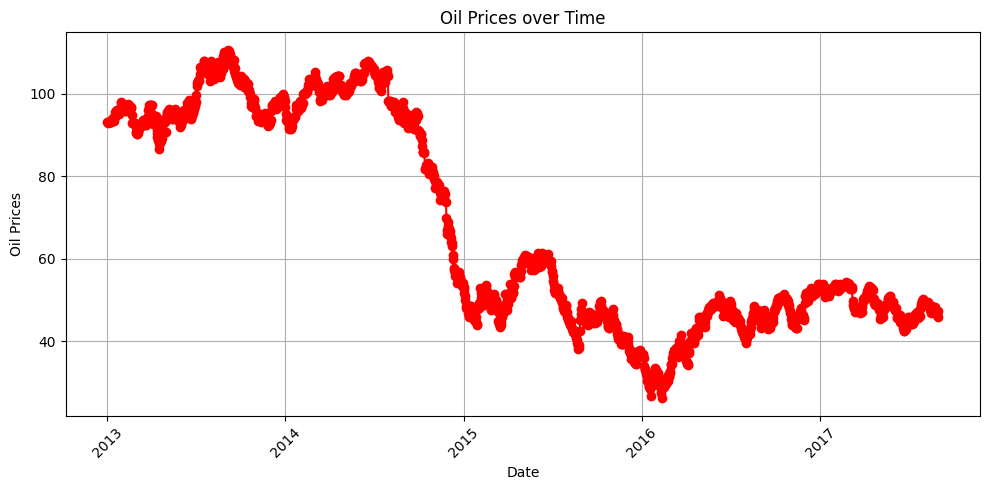

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(oil['date'], oil['dcoilwtico'], marker = 'o', linestyle = '-', color = 'red')
plt.title("Oil Prices over Time")
plt.xlabel("Date")
plt.ylabel("Oil Prices")
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

/opt/anaconda3/envs/proj/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


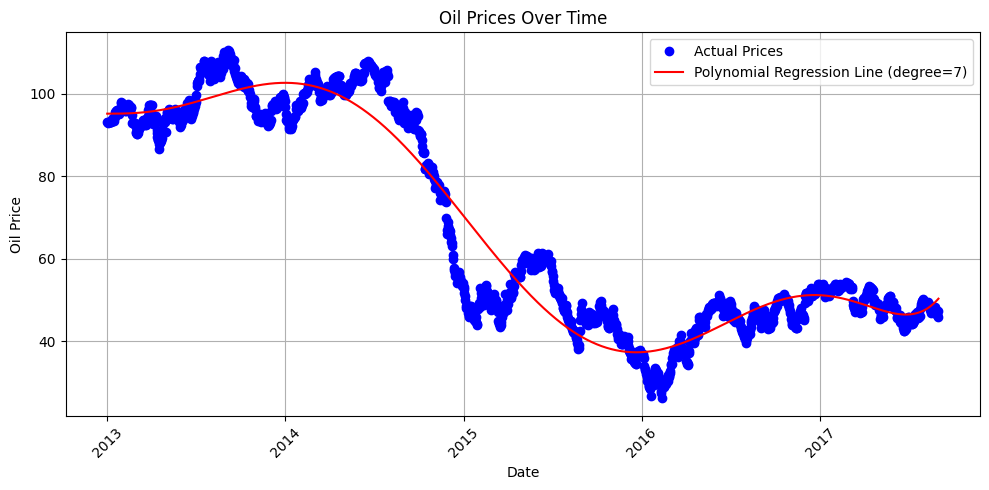

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

start_date = oil['date'].min()
oil['days_since_start'] = (oil['date'] - start_date).dt.days

X_train = oil[['days_since_start']]
y_train = oil['dcoilwtico']

degree = 7

poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_train)

model = LinearRegression()
model.fit(X_poly, y_train)

X_all = poly_features.transform(oil['days_since_start'].values.reshape(-1, 1))
predicted_dcoilwtico = model.predict(X_all)

plt.figure(figsize=(10, 5))
plt.plot(oil['date'], oil['dcoilwtico'], marker='o', linestyle='', color='blue', label='Actual Prices')
plt.plot(oil['date'], predicted_dcoilwtico, linestyle='-', color='red', label='Polynomial Regression Line (degree={})'.format(degree))
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

In [29]:
num_lags = 7

for lag in range(1, num_lags + 1):
    oil[f'dcoilwtico_lag{lag}'] = oil['dcoilwtico'].shift(lag)

In [30]:
train_oil = oil[oil['date'] <= '2017-08-15']
test_oil = oil[oil['date'] > '2017-08-15']

In [31]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [32]:
transactions.tail()

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


In [33]:
transaction_per_store = transactions.groupby('store_nbr')['transactions'].sum().reset_index()
store = pd.merge(store, transaction_per_store, on='store_nbr', how='right')

In [34]:
store.rename(columns={'transactions': 'total_store_transactions'}, inplace=True)

In [35]:
transactions['store_nbr'].unique().size

54

In [36]:
store.head()

,store_nbr,city,state,type,cluster,total_store_sales,total_store_promotion,total_store_transactions
0,1,Quito,Pichincha,D,13,1.414501e+07,138020,2553963
1,2,Quito,Pichincha,D,13,2.155739e+07,158149,3219901
2,3,Quito,Pichincha,D,8,5.048191e+07,177075,5366350
3,4,Quito,Pichincha,D,9,1.890970e+07,151932,2519007
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4,1.559240e+07,149370,2347877


In [37]:
store['promotion_impact_on_transactions'] =  store['total_store_transactions'] / store['total_store_promotion']
store['average_transaction_value'] = store['total_store_sales'] / store['total_store_transactions']
store['promotion_impact_on_sales'] = store['total_store_sales'] / store['total_store_promotion'].replace(0, 1)

In [38]:
store['city_state'] = store['city'] + '_' + store['state']
store['city_type'] = store['city'] + '_' + store['type']
store['state_type'] = store['state'] + '_' + store['type']
store['city_state_type'] = store['city'] + '_' + store['state'] + '_' + store['type']

In [39]:
store.head()

,store_nbr,city,state,type,cluster,total_store_sales,total_store_promotion,total_store_transactions,promotion_impact_on_transactions,average_transaction_value,promotion_impact_on_sales,city_state,city_type,state_type,city_state_type
0,1,Quito,Pichincha,D,13,1.414501e+07,138020,2553963,18.504296,5.538456,102.485240,Quito_Pichincha,Quito_D,Pichincha_D,Quito_Pichincha_D
1,2,Quito,Pichincha,D,13,2.155739e+07,158149,3219901,20.359920,6.695047,136.310623,Quito_Pichincha,Quito_D,Pichincha_D,Quito_Pichincha_D
2,3,Quito,Pichincha,D,8,5.048191e+07,177075,5366350,30.305520,9.407122,285.087732,Quito_Pichincha,Quito_D,Pichincha_D,Quito_Pichincha_D
3,4,Quito,Pichincha,D,9,1.890970e+07,151932,2519007,16.579832,7.506807,124.461604,Quito_Pichincha,Quito_D,Pichincha_D,Quito_Pichincha_D
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4,1.559240e+07,149370,2347877,15.718531,6.641065,104.387793,Santo Domingo_Santo Domingo de los Tsachilas,Santo Domingo_D,Santo Domingo de los Tsachilas_D,Santo Domingo_Santo Domingo de los Tsachilas_D


In [40]:
for col in ['city', 'state', 'type', 'city_state', 'city_type', 'state_type', 'city_state_type']:
    store[col] = store[col].astype('category').cat.codes

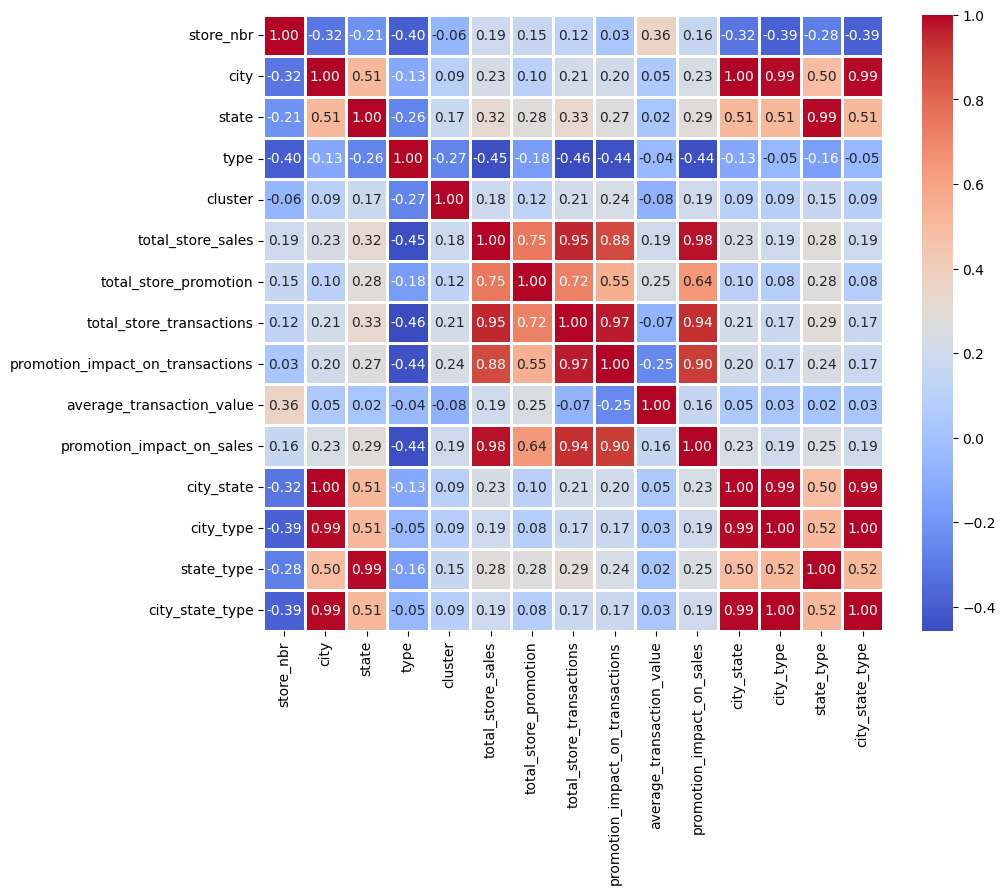

In [41]:
corr_matrix = store.corr()
plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.8)
plt.show()

In [42]:
store = store.drop(['city_state', 'city_type', 'state_type', 'city_state_type'], axis=1)

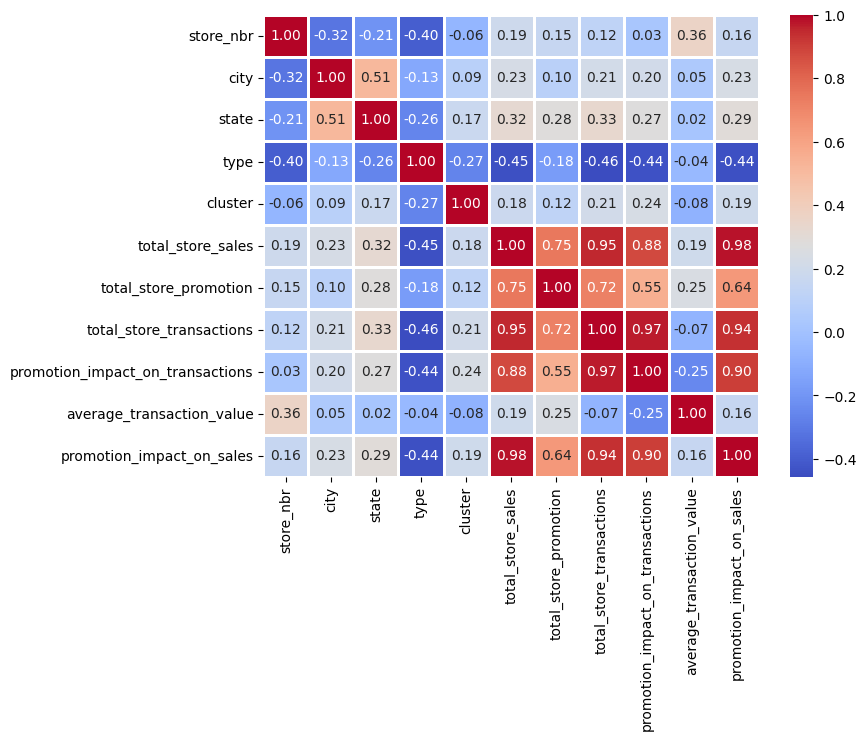

In [43]:
corr_matrix = store.corr()
plt.figure(figsize=(8, 6))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.8)
plt.show()

In [44]:
store[(store['total_store_promotion'] < 50000) | (store['average_transaction_value'] == store['average_transaction_value'].min())]

,store_nbr,city,state,type,cluster,total_store_sales,total_store_promotion,total_store_transactions,promotion_impact_on_transactions,average_transaction_value,promotion_impact_on_sales
33,34,8,6,1,6,1.709073e+07,150651,3864018,25.648804,4.423047,113.445873
51,52,14,10,0,11,2.696170e+06,30814,275393,8.937269,9.790262,87.498206


In [45]:
len(train)

3000888

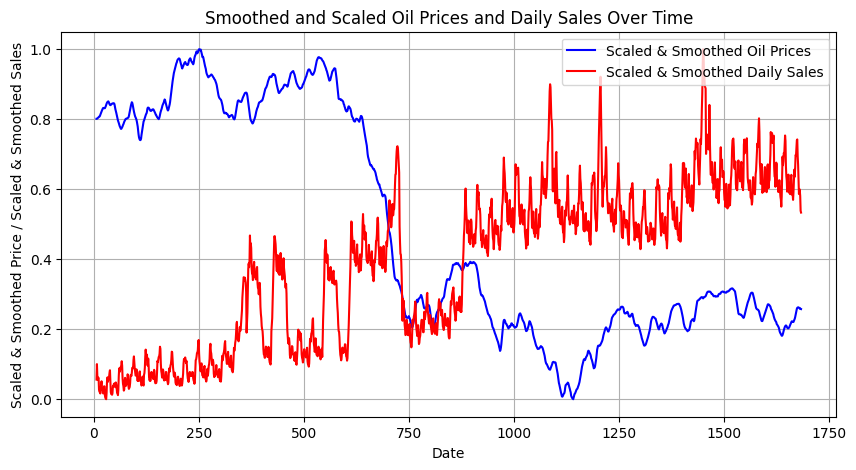

In [46]:
from sklearn.preprocessing import MinMaxScaler

sales = train.groupby('date')['sales'].sum().reset_index()
merged_df = pd.merge(oil, sales['sales'], left_index=True, right_index=True)

window_size = 8
merged_df['dcoilwtico_smooth'] = merged_df['dcoilwtico'].rolling(window=window_size).mean()
merged_df['sales_smooth'] = merged_df['sales'].rolling(window=window_size).mean()

scaler = MinMaxScaler()
merged_df_scaled = merged_df.copy()

merged_df_scaled[['dcoilwtico_smooth', 'sales_smooth']] = scaler.fit_transform(merged_df_scaled[['dcoilwtico_smooth', 'sales_smooth']])

plt.figure(figsize=(10, 5))
plt.plot(merged_df_scaled.index, merged_df_scaled['dcoilwtico_smooth'], linestyle='-', color='blue', label='Scaled & Smoothed Oil Prices')
plt.plot(merged_df_scaled.index, merged_df_scaled['sales_smooth'], linestyle='-', color='red', label='Scaled & Smoothed Daily Sales')
plt.title('Smoothed and Scaled Oil Prices and Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Scaled & Smoothed Price / Scaled & Smoothed Sales')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
merged_df.head(8)

,date,dcoilwtico,days_since_start,dcoilwtico_lag1,dcoilwtico_lag2,dcoilwtico_lag3,dcoilwtico_lag4,dcoilwtico_lag5,dcoilwtico_lag6,dcoilwtico_lag7,sales,dcoilwtico_smooth,sales_smooth
0,2013-01-01,93.055000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2511.618999,NaN,NaN
1,2013-01-02,93.140000,1,93.055000,NaN,NaN,NaN,NaN,NaN,NaN,496092.417944,NaN,NaN
2,2013-01-03,92.970000,2,93.140000,93.055000,NaN,NaN,NaN,NaN,NaN,361461.231124,NaN,NaN
3,2013-01-04,93.120000,3,92.970000,93.140000,93.055000,NaN,NaN,NaN,NaN,354459.677093,NaN,NaN
4,2013-01-05,93.146667,4,93.120000,92.970000,93.140000,93.055,NaN,NaN,NaN,477350.121229,NaN,NaN
5,2013-01-06,93.173333,5,93.146667,93.120000,92.970000,93.140,93.055,NaN,NaN,519695.401088,NaN,NaN
6,2013-01-07,93.200000,6,93.173333,93.146667,93.120000,92.970,93.140,93.055,NaN,336122.801066,NaN,NaN
7,2013-01-08,93.210000,7,93.200000,93.173333,93.146667,93.120,92.970,93.140,93.055,318347.777981,93.126875,358255.130815


In [48]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,day,month,year,holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,1,2013,1
1,1,2013-01-01,1,BABY CARE,0.0,0,1,1,2013,1
2,2,2013-01-01,1,BEAUTY,0.0,0,1,1,2013,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,1,1,2013,1
4,4,2013-01-01,1,BOOKS,0.0,0,1,1,2013,1


In [49]:
columns_to_merge = ['store_nbr', 'city', 'state', 'type', 'cluster', 'total_store_promotion']
train = pd.merge(train, store[columns_to_merge], on='store_nbr', how='right')

In [50]:
holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [51]:
for lag in range(1, 8):
    train[f'sales_lag{lag}'] = train.groupby(['store_nbr', 'family'])['sales'].shift(lag)

for lag in range(1, num_lags + 1):
    train[f'onpromotion_lag{lag}'] = train.groupby(['store_nbr', 'family'])['onpromotion'].shift(lag)

In [52]:
train.head(8)

,id,date,store_nbr,family,sales,onpromotion,day,month,year,holiday,...,sales_lag5,sales_lag6,sales_lag7,onpromotion_lag1,onpromotion_lag2,onpromotion_lag3,onpromotion_lag4,onpromotion_lag5,onpromotion_lag6,onpromotion_lag7
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,1,2013,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,1,1,2013,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,1,1,2013,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,1,1,2013,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,1,1,2013,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0,1,1,2013,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,2013-01-01,1,CELEBRATION,0.0,0,1,1,2013,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,2013-01-01,1,CLEANING,0.0,0,1,1,2013,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
daily_promo_per_product_across_all_stores = train.groupby(['date', 'family'])['onpromotion'].sum().reset_index()
daily_promo_per_store = train.groupby(['date', 'store_nbr'])['onpromotion'].sum().reset_index()
daily_promo_across_stores = train.groupby('date')['onpromotion'].sum().reset_index()

In [54]:
daily_promo_per_product_across_all_stores = daily_promo_per_product_across_all_stores.rename(columns={'onpromotion': 'daily_promo_per_product_across_all_stores'})
for lag in range(1, 8):
    daily_promo_per_product_across_all_stores[f'daily_promo_per_product_across_all_stores_lag{lag}'] = daily_promo_per_product_across_all_stores.groupby(['family'])['daily_promo_per_product_across_all_stores'].shift(lag)

In [55]:
daily_promo_per_store = daily_promo_per_store.rename(columns={'onpromotion': 'daily_promo_per_store'})
for lag in range(1, 8):
    daily_promo_per_store[f'daily_promo_per_store_lag{lag}'] = daily_promo_per_store.groupby(['store_nbr'])['daily_promo_per_store'].shift(lag)

In [56]:
daily_promo_per_store.tail()

,date,store_nbr,daily_promo_per_store,daily_promo_per_store_lag1,daily_promo_per_store_lag2,daily_promo_per_store_lag3,daily_promo_per_store_lag4,daily_promo_per_store_lag5,daily_promo_per_store_lag6,daily_promo_per_store_lag7
90931,2017-08-15,50,150,150.0,157.0,155.0,344.0,138.0,374.0,150.0
90932,2017-08-15,51,127,132.0,145.0,139.0,312.0,101.0,367.0,131.0
90933,2017-08-15,52,142,137.0,142.0,143.0,339.0,134.0,359.0,136.0
90934,2017-08-15,53,114,117.0,127.0,124.0,280.0,95.0,280.0,113.0
90935,2017-08-15,54,204,126.0,173.0,138.0,166.0,133.0,180.0,196.0


In [57]:
daily_promo_across_stores = daily_promo_across_stores.rename(columns={'onpromotion': 'daily_promo_across_stores'})
for lag in range(1, 8):
    daily_promo_across_stores[f'daily_promo_across_stores_lag{lag}'] = daily_promo_across_stores['daily_promo_across_stores'].shift(lag)

In [58]:
train = pd.merge(train, daily_promo_per_product_across_all_stores, on=['date', 'family'], how='right', suffixes=('', '_per_product'))
train = pd.merge(train, daily_promo_per_store, on=['date', 'store_nbr'], how='right', suffixes=('', '_per_store'))
train = train.merge(daily_promo_across_stores, on='date', how='right', suffixes=('', '_across_stores'))

In [59]:
train.rename(columns={'onpromotion_per_product': 'daily_promo_per_product_across_all_stores', 'onpromotion_per_store': 'daily_promo_per_store', 'onpromotion_across_stores': 'daily_promo_across_stores'}, inplace=True)

In [60]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,day,month,year,holiday,...,daily_promo_per_store_lag6,daily_promo_per_store_lag7,daily_promo_across_stores,daily_promo_across_stores_lag1,daily_promo_across_stores_lag2,daily_promo_across_stores_lag3,daily_promo_across_stores_lag4,daily_promo_across_stores_lag5,daily_promo_across_stores_lag6,daily_promo_across_stores_lag7
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,1,2013,1,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,1,1,2013,1,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,1,1,2013,1,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,1,1,2013,1,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,1,1,2013,1,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
unique_rows = train.drop_duplicates(subset='daily_promo_per_product_across_all_stores')

unique_rows.head()

,id,date,store_nbr,family,sales,onpromotion,day,month,year,holiday,...,daily_promo_per_store_lag6,daily_promo_per_store_lag7,daily_promo_across_stores,daily_promo_across_stores_lag1,daily_promo_across_stores_lag2,daily_promo_across_stores_lag3,daily_promo_across_stores_lag4,daily_promo_across_stores_lag5,daily_promo_across_stores_lag6,daily_promo_across_stores_lag7
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,1,1,2013,1,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
809035,809035,2014-04-01,1,CLEANING,731.000,0,1,4,2014,0,...,0.0,0.0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
809040,809040,2014-04-01,1,GROCERY I,2471.000,0,1,4,2014,0,...,0.0,0.0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
810838,810838,2014-04-02,1,POULTRY,461.016,0,2,4,2014,0,...,0.0,0.0,4,8.0,0.0,0.0,0.0,0.0,0.0,0.0
812601,812601,2014-04-03,1,DELI,111.730,0,3,4,2014,0,...,0.0,0.0,120,4.0,8.0,0.0,0.0,0.0,0.0,0.0


In [62]:
filtered_df = train[train['date'] == '2014-04-01']

unique_values = filtered_df['daily_promo_per_store'].value_counts()

print(unique_values)

daily_promo_per_store
0    1749
8      33
Name: count, dtype: int64


In [63]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Column Name', 'Data Type', 'Null Count']
for column in train.columns:
    data_type = str(train[column].dtype)
    null_count = train[column].isnull().sum()
    table.add_row([column, data_type, null_count])
print(table)

+------------------------------------------------+----------------+------------+
|                  Column Name                   |   Data Type    | Null Count |
+------------------------------------------------+----------------+------------+
|                       id                       |     int64      |     0      |
|                      date                      | datetime64[ns] |     0      |
|                   store_nbr                    |     int64      |     0      |
|                     family                     |     object     |     0      |
|                     sales                      |    float64     |     0      |
|                  onpromotion                   |     int64      |     0      |
|                      day                       |     int32      |     0      |
|                     month                      |     int32      |     0      |
|                      year                      |     int32      |     0      |
|                    holiday

In [64]:
train = pd.merge(train, train_oil, on='date', how='right')

In [65]:
train = train.dropna(subset=['id'])
train = train.fillna(0.0)

In [66]:
train['family'] = train['family'].astype('category').cat.codes

In [67]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,day,month,year,holiday,...,daily_promo_across_stores_lag7,dcoilwtico,days_since_start,dcoilwtico_lag1,dcoilwtico_lag2,dcoilwtico_lag3,dcoilwtico_lag4,dcoilwtico_lag5,dcoilwtico_lag6,dcoilwtico_lag7
0,0.0,2013-01-01,1.0,0,0.0,0.0,1.0,1.0,2013.0,1.0,...,0.0,93.055,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2013-01-01,1.0,1,0.0,0.0,1.0,1.0,2013.0,1.0,...,0.0,93.055,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,2013-01-01,1.0,2,0.0,0.0,1.0,1.0,2013.0,1.0,...,0.0,93.055,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,2013-01-01,1.0,3,0.0,0.0,1.0,1.0,2013.0,1.0,...,0.0,93.055,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,2013-01-01,1.0,4,0.0,0.0,1.0,1.0,2013.0,1.0,...,0.0,93.055,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
table = PrettyTable()
table.field_names = ['Column Name', 'Data Type', 'Null Count']
for column in train.columns:
    data_type = str(train[column].dtype)
    null_count = train[column].isnull().sum()
    table.add_row([column, data_type, null_count])
print(table)

+------------------------------------------------+----------------+------------+
|                  Column Name                   |   Data Type    | Null Count |
+------------------------------------------------+----------------+------------+
|                       id                       |    float64     |     0      |
|                      date                      | datetime64[ns] |     0      |
|                   store_nbr                    |    float64     |     0      |
|                     family                     |      int8      |     0      |
|                     sales                      |    float64     |     0      |
|                  onpromotion                   |    float64     |     0      |
|                      day                       |    float64     |     0      |
|                     month                      |    float64     |     0      |
|                      year                      |    float64     |     0      |
|                    holiday

In [69]:
pd.set_option('display.max_columns', None)
train.head()

,id,date,store_nbr,family,sales,onpromotion,day,month,year,holiday,city,state,type,cluster,total_store_promotion,sales_lag1,sales_lag2,sales_lag3,sales_lag4,sales_lag5,sales_lag6,sales_lag7,onpromotion_lag1,onpromotion_lag2,onpromotion_lag3,onpromotion_lag4,onpromotion_lag5,onpromotion_lag6,onpromotion_lag7,daily_promo_per_product_across_all_stores,daily_promo_per_product_across_all_stores_lag1,daily_promo_per_product_across_all_stores_lag2,daily_promo_per_product_across_all_stores_lag3,daily_promo_per_product_across_all_stores_lag4,daily_promo_per_product_across_all_stores_lag5,daily_promo_per_product_across_all_stores_lag6,daily_promo_per_product_across_all_stores_lag7,daily_promo_per_store,daily_promo_per_store_lag1,daily_promo_per_store_lag2,daily_promo_per_store_lag3,daily_promo_per_store_lag4,daily_promo_per_store_lag5,daily_promo_per_store_lag6,daily_promo_per_store_lag7,daily_promo_across_stores,daily_promo_across_stores_lag1,daily_promo_across_stores_lag2,daily_promo_across_stores_lag3,daily_promo_across_stores_lag4,daily_promo_across_stores_lag5,daily_promo_across_stores_lag6,daily_promo_across_stores_lag7,dcoilwtico,days_since_start,dcoilwtico_lag1,dcoilwtico_lag2,dcoilwtico_lag3,dcoilwtico_lag4,dcoilwtico_lag5,dcoilwtico_lag6,dcoilwtico_lag7
0,0.0,2013-01-01,1.0,0,0.0,0.0,1.0,1.0,2013.0,1.0,18.0,12.0,3.0,13.0,138020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.055,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2013-01-01,1.0,1,0.0,0.0,1.0,1.0,2013.0,1.0,18.0,12.0,3.0,13.0,138020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.055,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,2013-01-01,1.0,2,0.0,0.0,1.0,1.0,2013.0,1.0,18.0,12.0,3.0,13.0,138020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.055,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,2013-01-01,1.0,3,0.0,0.0,1.0,1.0,2013.0,1.0,18.0,12.0,3.0,13.0,138020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.055,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,2013-01-01,1.0,4,0.0,0.0,1.0,1.0,2013.0,1.0,18.0,12.0,3.0,13.0,138020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.055,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
train.tail()

,id,date,store_nbr,family,sales,onpromotion,day,month,year,holiday,city,state,type,cluster,total_store_promotion,sales_lag1,sales_lag2,sales_lag3,sales_lag4,sales_lag5,sales_lag6,sales_lag7,onpromotion_lag1,onpromotion_lag2,onpromotion_lag3,onpromotion_lag4,onpromotion_lag5,onpromotion_lag6,onpromotion_lag7,daily_promo_per_product_across_all_stores,daily_promo_per_product_across_all_stores_lag1,daily_promo_per_product_across_all_stores_lag2,daily_promo_per_product_across_all_stores_lag3,daily_promo_per_product_across_all_stores_lag4,daily_promo_per_product_across_all_stores_lag5,daily_promo_per_product_across_all_stores_lag6,daily_promo_per_product_across_all_stores_lag7,daily_promo_per_store,daily_promo_per_store_lag1,daily_promo_per_store_lag2,daily_promo_per_store_lag3,daily_promo_per_store_lag4,daily_promo_per_store_lag5,daily_promo_per_store_lag6,daily_promo_per_store_lag7,daily_promo_across_stores,daily_promo_across_stores_lag1,daily_promo_across_stores_lag2,daily_promo_across_stores_lag3,daily_promo_across_stores_lag4,daily_promo_across_stores_lag5,daily_promo_across_stores_lag6,daily_promo_across_stores_lag7,dcoilwtico,days_since_start,dcoilwtico_lag1,dcoilwtico_lag2,dcoilwtico_lag3,dcoilwtico_lag4,dcoilwtico_lag5,dcoilwtico_lag6,dcoilwtico_lag7
3000887,3000751.0,2017-08-15,54.0,28,59.619,0.0,15.0,8.0,2017.0,0.0,5.0,10.0,2.0,3.0,142724.0,56.155,79.062996,91.671,80.759,49.666,51.015,73.289,0.0,0.0,0.0,10.0,0.0,0.0,0.0,6.0,7.0,10.0,6.0,1480.0,13.0,14.0,11.0,204.0,126.0,173.0,138.0,166.0,133.0,180.0,196.0,10605.0,8043.0,9283.0,8312.0,14179.0,7917.0,16117.0,10638.0,47.57,1687,47.59,47.996667,48.403333,48.81,48.54,49.59,49.07
3000888,3000752.0,2017-08-15,54.0,29,94.000,0.0,15.0,8.0,2017.0,0.0,5.0,10.0,2.0,3.0,142724.0,147.000,91.000000,81.000,54.000,61.000,91.000,86.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,8.0,12.0,15.0,29.0,11.0,11.0,12.0,204.0,126.0,173.0,138.0,166.0,133.0,180.0,196.0,10605.0,8043.0,9283.0,8312.0,14179.0,7917.0,16117.0,10638.0,47.57,1687,47.59,47.996667,48.403333,48.81,48.54,49.59,49.07
3000889,3000753.0,2017-08-15,54.0,30,915.371,76.0,15.0,8.0,2017.0,0.0,5.0,10.0,2.0,3.0,142724.0,585.615,877.304000,696.920,546.250,498.122,595.185,790.013,3.0,4.0,4.0,3.0,3.0,2.0,71.0,3169.0,325.0,319.0,324.0,324.0,313.0,5630.0,3086.0,204.0,126.0,173.0,138.0,166.0,133.0,180.0,196.0,10605.0,8043.0,9283.0,8312.0,14179.0,7917.0,16117.0,10638.0,47.57,1687,47.59,47.996667,48.403333,48.81,48.54,49.59,49.07
3000890,3000754.0,2017-08-15,54.0,31,0.000,0.0,15.0,8.0,2017.0,0.0,5.0,10.0,2.0,3.0,142724.0,0.000,0.000000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,148.0,154.0,150.0,149.0,144.0,140.0,127.0,121.0,204.0,126.0,173.0,138.0,166.0,133.0,180.0,196.0,10605.0,8043.0,9283.0,8312.0,14179.0,7917.0,16117.0,10638.0,47.57,1687,47.59,47.996667,48.403333,48.81,48.54,49.59,49.07
3000891,3000755.0,2017-08-15,54.0,32,3.000,0.0,15.0,8.0,2017.0,0.0,5.0,10.0,2.0,3.0,142724.0,0.000,2.000000,1.000,0.000,2.000,4.000,12.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,41.0,137.0,0.0,1.0,0.0,204.0,126.0,173.0,138.0,166.0,133.0,180.0,196.0,10605.0,8043.0,9283.0,8312.0,14179.0,7917.0,16117.0,10638.0,47.57,1687,47.59,47.996667,48.403333,48.81,48.54,49.59,49.07


In [71]:
sales_column = train.pop('sales')
train['sales'] = sales_column

In [72]:
train = train.drop('id', axis=1)

In [73]:
train.head()

,date,store_nbr,family,onpromotion,day,month,year,holiday,city,state,type,cluster,total_store_promotion,sales_lag1,sales_lag2,sales_lag3,sales_lag4,sales_lag5,sales_lag6,sales_lag7,onpromotion_lag1,onpromotion_lag2,onpromotion_lag3,onpromotion_lag4,onpromotion_lag5,onpromotion_lag6,onpromotion_lag7,daily_promo_per_product_across_all_stores,daily_promo_per_product_across_all_stores_lag1,daily_promo_per_product_across_all_stores_lag2,daily_promo_per_product_across_all_stores_lag3,daily_promo_per_product_across_all_stores_lag4,daily_promo_per_product_across_all_stores_lag5,daily_promo_per_product_across_all_stores_lag6,daily_promo_per_product_across_all_stores_lag7,daily_promo_per_store,daily_promo_per_store_lag1,daily_promo_per_store_lag2,daily_promo_per_store_lag3,daily_promo_per_store_lag4,daily_promo_per_store_lag5,daily_promo_per_store_lag6,daily_promo_per_store_lag7,daily_promo_across_stores,daily_promo_across_stores_lag1,daily_promo_across_stores_lag2,daily_promo_across_stores_lag3,daily_promo_across_stores_lag4,daily_promo_across_stores_lag5,daily_promo_across_stores_lag6,daily_promo_across_stores_lag7,dcoilwtico,days_since_start,dcoilwtico_lag1,dcoilwtico_lag2,dcoilwtico_lag3,dcoilwtico_lag4,dcoilwtico_lag5,dcoilwtico_lag6,dcoilwtico_lag7,sales
0,2013-01-01,1.0,0,0.0,1.0,1.0,2013.0,1.0,18.0,12.0,3.0,13.0,138020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.055,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-01,1.0,1,0.0,1.0,1.0,2013.0,1.0,18.0,12.0,3.0,13.0,138020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.055,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-01,1.0,2,0.0,1.0,1.0,2013.0,1.0,18.0,12.0,3.0,13.0,138020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.055,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-01-01,1.0,3,0.0,1.0,1.0,2013.0,1.0,18.0,12.0,3.0,13.0,138020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.055,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-01-01,1.0,4,0.0,1.0,1.0,2013.0,1.0,18.0,12.0,3.0,13.0,138020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.055,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
train.corrwith(train['sales']).abs().sort_values(ascending=False)

sales         1.000000
sales_lag7    0.935089
sales_lag1    0.919033
sales_lag6    0.900636
sales_lag2    0.879262
                ...   
store_nbr     0.041196
cluster       0.038525
month         0.019790
holiday       0.016559
day           0.011887
Length: 61, dtype: float64

**GRAPH PLOTS**

In [75]:
from pathlib import Path
from warnings import simplefilter
from scipy.signal import periodogram

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("1D") / pd.Timedelta("1D")
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()

    mask = (frequencies >= 1/365) & (frequencies <= 104/365)

    frequencies_filtered = frequencies[mask]
    spectrum_filtered = spectrum[mask]

    idx_max = spectrum_filtered.argmax()
    frequency_of_max_variance = frequencies_filtered[idx_max]
    max_variance = spectrum_filtered[idx_max]

    ax.step(frequencies_filtered, spectrum_filtered, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1/365, 2/365, 4/365, 6/365, 12/365, 26/365, 52/365, 104/365])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")

    interval_in_days = round(1/frequency_of_max_variance)
    ax.annotate(f'Max Variance\noccurs at {interval_in_days} days interval\n(split into {interval_in_days} day intervals)',
                xy=(frequency_of_max_variance, max_variance),
                xytext=(frequency_of_max_variance*0.5, max_variance*2),
                arrowprops=dict(facecolor='red', shrink=0.05),
                horizontalalignment='right')

    return ax, frequency_of_max_variance, max_variance, interval_in_days



tunnel = pd.read_csv("train.csv", parse_dates=["date"])
tunnel = tunnel.set_index("date").to_period("D")

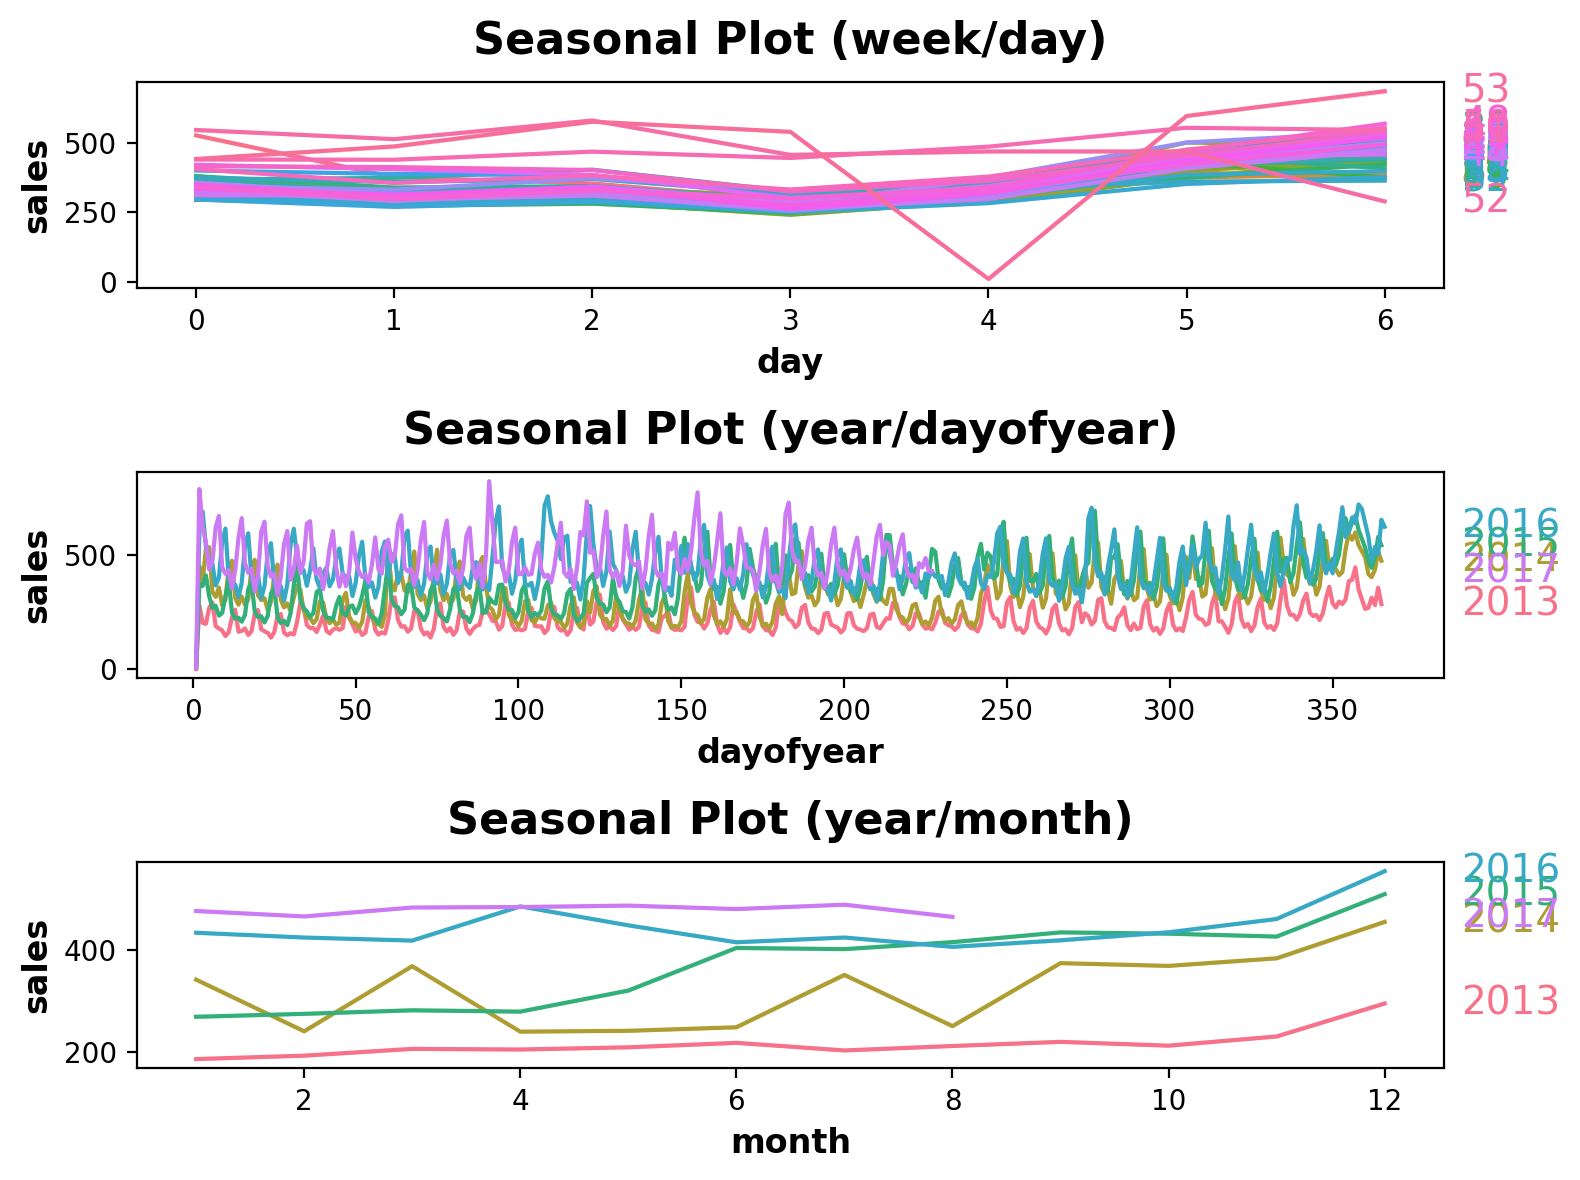

In [98]:
X = tunnel.copy()

X["day"] = X.index.dayofweek 
X["week"] = X.index.week 

X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

X["month"] = X.index.month  # Add month as a feature

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(8, 6))
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1)
seasonal_plot(X, y="sales", period="year", freq="month", ax=ax2)

plt.show()

The frequency with the maximum variance is: 0.21212121212121213 and max variance is 74659.0919870994
Intervals of days is 5


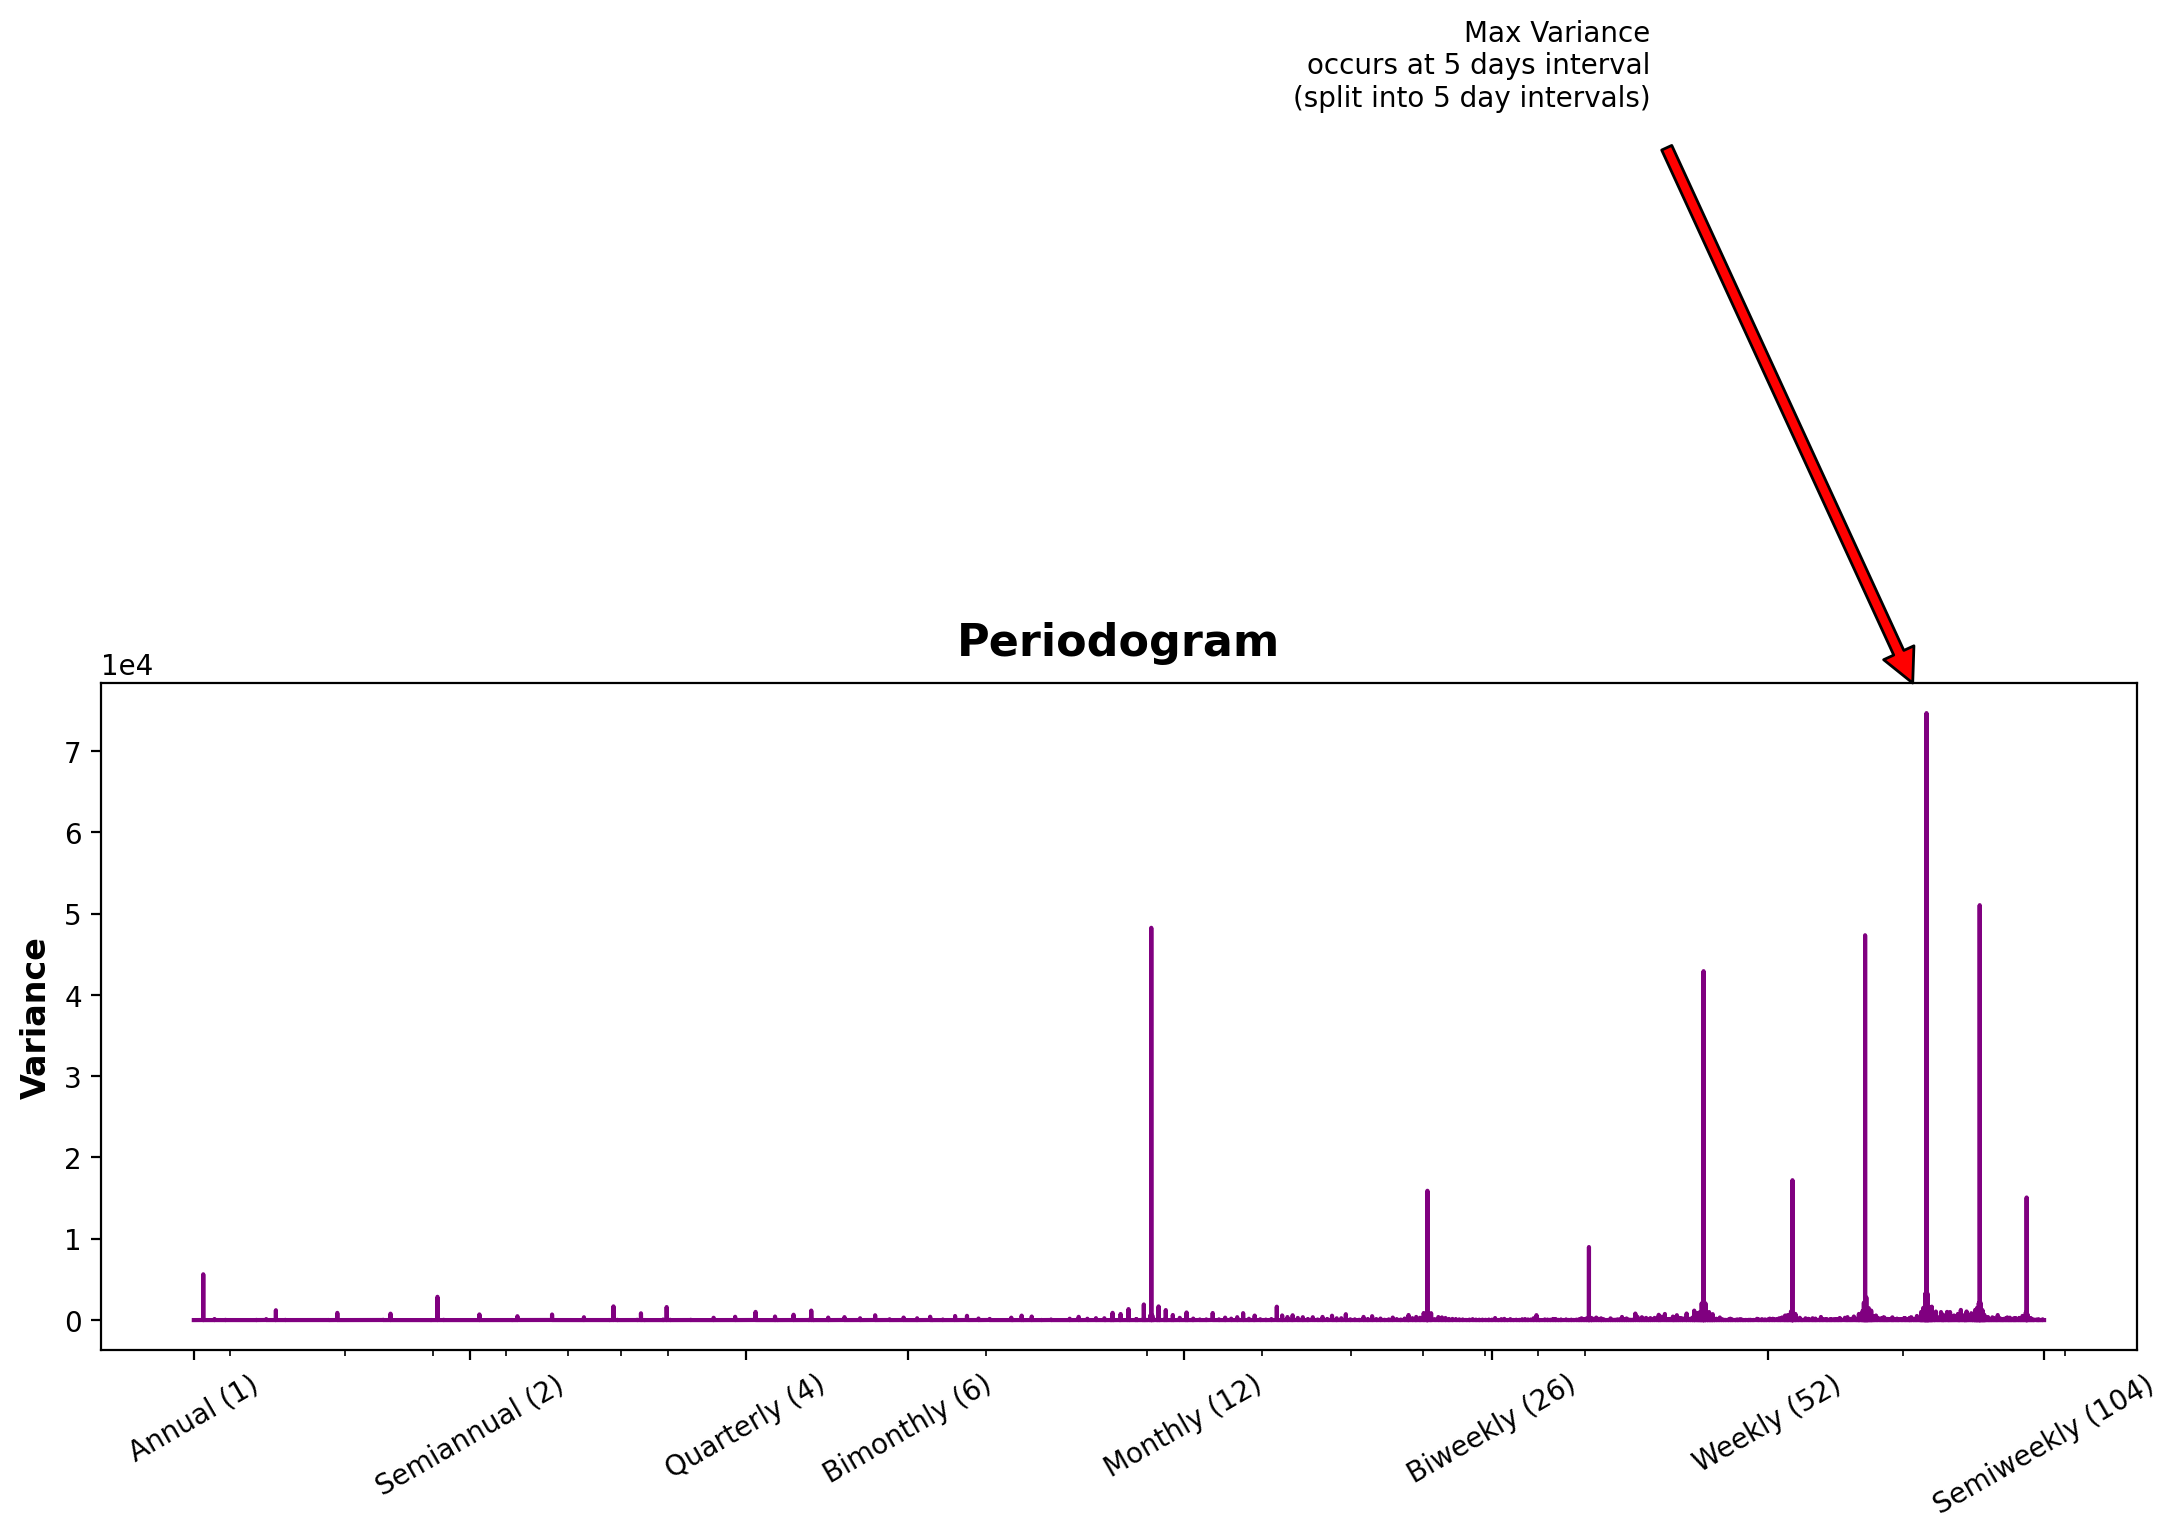

In [99]:
ax, max_variance_freq, max_variance, days = plot_periodogram(tunnel.sales);
print(f"The frequency with the maximum variance is: {max_variance_freq} and max variance is {max_variance}")
print(f"Intervals of days is {days}")

In [78]:
train.corrwith(train['sales']).abs().sort_values(ascending=False)

sales         1.000000
sales_lag7    0.935089
sales_lag1    0.919033
sales_lag6    0.900636
sales_lag2    0.879262
                ...   
store_nbr     0.041196
cluster       0.038525
month         0.019790
holiday       0.016559
day           0.011887
Length: 61, dtype: float64

**PACF**

In [79]:
from statsmodels.tsa.stattools import pacf

lags = 7
pacf_sales = pacf(train.sales, nlags=lags)
pacf_onpromotion = pacf(train.onpromotion, nlags=lags)
pacf_daily_promo_per_product_across_all_stores = pacf(train.daily_promo_per_product_across_all_stores, nlags=lags)
pacf_daily_promo_per_store = pacf(train.daily_promo_per_store, nlags=lags)
pacf_daily_promo_across_stores = pacf(train.daily_promo_across_stores, nlags=lags)
pacf_dcoilwtico = pacf(train.dcoilwtico, nlags=lags)

pacf_results = {
    'sales': pacf_sales,
    'onpromotion': pacf_onpromotion,
    'daily_promo_per_product_across_all_stores': pacf_daily_promo_per_product_across_all_stores,
    'daily_promo_per_store': pacf_daily_promo_per_store,
    'daily_promo_across_stores': pacf_daily_promo_across_stores,
    'dcoilwtico': pacf_dcoilwtico
}

import pandas as pd

pacf_df_list = []

for feature, values in pacf_results.items():
    for lag in range(1, len(values)):
        pacf_df_list.append({'Feature': feature, 'Lag': lag, 'PACF': values[lag]})

pacf_df = pd.DataFrame(pacf_df_list)

pacf_df.pivot(index='Lag', columns='Feature', values='PACF')

Feature,daily_promo_across_stores,daily_promo_per_product_across_all_stores,daily_promo_per_store,dcoilwtico,onpromotion,sales
Lag,,,,,,
1,0.999883,0.060165,0.994334,9.999997e-01,0.049535,-0.024169
2,-0.000059,0.041029,-0.002842,-4.892694e-07,0.036982,0.027971
3,-0.000059,0.057105,-0.002850,-4.839010e-07,0.046321,-0.029393
4,-0.000059,0.164482,-0.002858,-4.892284e-07,0.133380,0.121258
5,-0.000059,0.141969,-0.002866,-4.896211e-07,0.116693,0.151450
6,-0.000059,0.085424,-0.002874,-4.869628e-07,0.063872,0.125441
7,-0.000059,-0.016943,-0.002883,-4.861642e-07,-0.004676,0.002257


In [80]:
autocorr_results = {}

for lag in range(1, 8):
    column_name = f'onpromotion_lag{lag}'
    autocorr_results[f'Autocorr_{column_name}'] = train['onpromotion'].autocorr(lag)

autocorr_df = pd.DataFrame(autocorr_results.items(), columns=['Lagged Feature', 'Autocorrelation'])
print(autocorr_df)

              Lagged Feature  Autocorrelation
0  Autocorr_onpromotion_lag1         0.049535
1  Autocorr_onpromotion_lag2         0.039345
2  Autocorr_onpromotion_lag3         0.049853
3  Autocorr_onpromotion_lag4         0.138542
4  Autocorr_onpromotion_lag5         0.129141
5  Autocorr_onpromotion_lag6         0.080843
6  Autocorr_onpromotion_lag7         0.017884


In [81]:
from statsmodels.tsa.stattools import acf

lags = 7
pacf_sales = pacf(train['sales'], nlags=lags)
pacf_onpromotion = pacf(train['onpromotion'], nlags=lags)

pacf_daily_promo_per_product_across_all_stores = pacf_sales
pacf_daily_promo_per_store = pacf_sales
pacf_daily_promo_across_stores = pacf_sales
pacf_dcoilwtico = pacf_sales

pacf_results = {
    'sales': pacf_sales,
    'onpromotion': pacf_onpromotion,
    'daily_promo_per_product_across_all_stores': pacf_daily_promo_per_product_across_all_stores,
    'daily_promo_per_store': pacf_daily_promo_per_store,
    'daily_promo_across_stores': pacf_daily_promo_across_stores,
    'dcoilwtico': pacf_dcoilwtico
}

acf_sales = acf(train['sales'], nlags=lags)
acf_onpromotion = acf(train['onpromotion'], nlags=lags)

acf_daily_promo_per_product_across_all_stores = acf_sales
acf_daily_promo_per_store = acf_sales
acf_daily_promo_across_stores = acf_sales
acf_dcoilwtico = acf_sales

acf_results = {
    'sales': acf_sales,
    'onpromotion': acf_onpromotion,
    'daily_promo_per_product_across_all_stores': acf_daily_promo_per_product_across_all_stores,
    'daily_promo_per_store': acf_daily_promo_per_store,
    'daily_promo_across_stores': acf_daily_promo_across_stores,
    'dcoilwtico': acf_dcoilwtico
}

pacf_acf_df_list = []

for feature, values in pacf_results.items():
    for lag in range(1, len(values)):
        pacf_acf_df_list.append({
            'Feature': feature,
            'Lag': lag,
            'PACF': values[lag],
            'Type': 'PACF'
        })

for feature, values in acf_results.items():
    for lag in range(1, len(values)):
        pacf_acf_df_list.append({
            'Feature': feature,
            'Lag': lag,
            'ACF': values[lag],
            'Type': 'ACF'
        })

pacf_acf_df = pd.DataFrame(pacf_acf_df_list)

# Separating PACF and ACF values
pacf_df = pacf_acf_df[pacf_acf_df['Type'] == 'PACF'].pivot(index='Lag', columns='Feature', values='PACF')
acf_df = pacf_acf_df[pacf_acf_df['Type'] == 'ACF'].pivot(index='Lag', columns='Feature', values='ACF')

acf_df

Feature,daily_promo_across_stores,daily_promo_per_product_across_all_stores,daily_promo_per_store,dcoilwtico,onpromotion,sales
Lag,,,,,,
1,-0.024169,-0.024169,-0.024169,-0.024169,0.049535,-0.024169
2,0.028539,0.028539,0.028539,0.028539,0.039345,0.028539
3,-0.030699,-0.030699,-0.030699,-0.030699,0.049853,-0.030699
4,0.123172,0.123172,0.123172,0.123172,0.138541,0.123172
5,0.142110,0.142110,0.142110,0.142110,0.129141,0.142110
6,0.119429,0.119429,0.119429,0.119429,0.080843,0.119429
7,-0.008384,-0.008384,-0.008384,-0.008384,0.017884,-0.008384


In [82]:
lags_to_keep = [
    'daily_promo_across_stores_lag1',
    'daily_promo_per_product_across_all_stores_lag4', 'daily_promo_per_product_across_all_stores_lag5', 'daily_promo_per_product_across_all_stores_lag6',
    'daily_promo_per_store_lag1',
    'dcoilwtico_lag1',
    'onpromotion_lag4', 'onpromotion_lag5', 'onpromotion_lag6',
    'sales_lag4', 'sales_lag5', 'sales_lag6'
]

train = train[[col for col in train.columns if col in lags_to_keep or not '_lag' in col]]

In [83]:
train.corrwith(train['sales']).abs().sort_values(ascending=False)

sales                                             1.000000
sales_lag6                                        0.900636
sales_lag5                                        0.870435
sales_lag4                                        0.868310
daily_promo_per_product_across_all_stores         0.440228
daily_promo_per_product_across_all_stores_lag4    0.435849
onpromotion                                       0.427923
daily_promo_per_product_across_all_stores_lag5    0.421130
daily_promo_per_product_across_all_stores_lag6    0.416364
onpromotion_lag4                                  0.404998
onpromotion_lag5                                  0.386484
onpromotion_lag6                                  0.375922
total_store_promotion                             0.160979
family                                            0.114159
daily_promo_per_store                             0.097941
type                                              0.095766
daily_promo_per_store_lag1                        0.0939

In [84]:
train.tail()

,date,store_nbr,family,onpromotion,day,month,year,holiday,city,state,type,cluster,total_store_promotion,sales_lag4,sales_lag5,sales_lag6,onpromotion_lag4,onpromotion_lag5,onpromotion_lag6,daily_promo_per_product_across_all_stores,daily_promo_per_product_across_all_stores_lag4,daily_promo_per_product_across_all_stores_lag5,daily_promo_per_product_across_all_stores_lag6,daily_promo_per_store,daily_promo_per_store_lag1,daily_promo_across_stores,daily_promo_across_stores_lag1,dcoilwtico,days_since_start,dcoilwtico_lag1,sales
3000887,2017-08-15,54.0,28,0.0,15.0,8.0,2017.0,0.0,5.0,10.0,2.0,3.0,142724.0,80.759,49.666,51.015,10.0,0.0,0.0,6.0,1480.0,13.0,14.0,204.0,126.0,10605.0,8043.0,47.57,1687,47.59,59.619
3000888,2017-08-15,54.0,29,0.0,15.0,8.0,2017.0,0.0,5.0,10.0,2.0,3.0,142724.0,54.000,61.000,91.000,0.0,0.0,0.0,9.0,29.0,11.0,11.0,204.0,126.0,10605.0,8043.0,47.57,1687,47.59,94.000
3000889,2017-08-15,54.0,30,76.0,15.0,8.0,2017.0,0.0,5.0,10.0,2.0,3.0,142724.0,546.250,498.122,595.185,3.0,3.0,2.0,3169.0,324.0,313.0,5630.0,204.0,126.0,10605.0,8043.0,47.57,1687,47.59,915.371
3000890,2017-08-15,54.0,31,0.0,15.0,8.0,2017.0,0.0,5.0,10.0,2.0,3.0,142724.0,0.000,0.000,0.000,0.0,0.0,0.0,148.0,144.0,140.0,127.0,204.0,126.0,10605.0,8043.0,47.57,1687,47.59,0.000
3000891,2017-08-15,54.0,32,0.0,15.0,8.0,2017.0,0.0,5.0,10.0,2.0,3.0,142724.0,0.000,2.000,4.000,0.0,0.0,0.0,0.0,137.0,0.0,1.0,204.0,126.0,10605.0,8043.0,47.57,1687,47.59,3.000


**LSTM MODEL**

In [85]:
import keras
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split

X = train.drop(['sales', 'date'], axis = 1)
Y = train['sales']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X[:3000], Y[:3000], test_size=0.2)

In [87]:
X_train.shape

(2400, 29)

In [88]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(40, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

In [89]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [90]:
model.fit(X_train, y_train, epochs=30, batch_size=64)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7851 - loss: 1.2445e-05
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7986 - loss: 1.0459e-05
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8143 - loss: 1.0572e-05
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7944 - loss: 1.1579e-05
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7996 - loss: 1.0607e-05
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8064 - loss: 9.4932e-06
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7879 - loss: 9.9455e-06
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8001 - loss: 9.7756e-06
Epoch 9/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8048 - loss: 9.5117e-06
Epoch 10/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7975 - loss: 1.0566e-05
Epoch 11/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8141 - loss: 1.0090e-05
Epoch 12/30
38/38 ━

In [91]:
predictions = model.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


**XGB MODEL**

In [92]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

X = train.drop(['sales', 'date'], axis = 1)
Y = train['sales']

In [93]:
X_train, X_testXGB, y_train, y_testXGB = train_test_split(X[:3000], Y[:3000], test_size = 0.2, random_state= 1)

In [94]:
modelXGB = XGBRegressor(objective='reg:squarederror', n_estimators = 1000)
modelXGB.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [95]:
predictionsXGB = model.predict(X_testXGB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


**SCORE EVALUATION**

In [96]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f"Accuracy for the LSTM Model: {test_acc}")
# print(f"Classification Report for the LSTM Model:\n {f1_score(y_test, predictions)}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7852 - loss: 1.1858e-05  
Accuracy for the LSTM Model: 0.778333306312561


In [97]:
from sklearn.metrics import mean_absolute_error
print(f"RMSLE for the XGB Model: {mean_absolute_error(y_testXGB, predictionsXGB)}")

RMSLE for the XGB Model: 91.57872511924784
